In [1]:
!pip install -q rasterio  # -q is for quiet installation, non-verbose

## Imports

In [2]:
import os
import torch
import numpy as np
import rasterio
import glob
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F

## Parameters

In [3]:
# Paths and settings
BASE_PATH      = '/kaggle/input/sentinel2-crop-mapping'
H5_PATH        = '/kaggle/working/tiles_2016-18_uint8.h5'
REGIONS        = ['lombardia', 'lombardia2']
YEARS          = ['data2016', 'data2017', 'data2018']
NUM_TIMESTEPS  = 32
NUM_CLASSES    = 22
BATCH_SIZE     = 64
NUM_WORKERS    = 4
PIN_MEMORY     = True
LR             = 0.01
NUM_EPOCHS     = 15
DEVICE         = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VALID_LABELS = set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

## Dataset Preprocessing and Loading

In [ ]:
# os.remove('/kaggle/working/tiles_2016-18_uint8.h5')

In [ ]:
# Preprocess: pack all tiles into one HDF5

if not os.path.exists(H5_PATH):
    print(f"Creating HDF5 archive at {H5_PATH}...")

    # gather tile directories
    tile_dirs = []
    for reg in REGIONS:
        for yr in YEARS:
            tile_dirs += glob.glob(os.path.join(BASE_PATH, reg, yr, '*'))
    N = len(tile_dirs)

    with h5py.File(H5_PATH, 'w') as hf:
        imgs = hf.create_dataset(
            'images',
            shape=(N, 9*NUM_TIMESTEPS, 48, 48),
            dtype='uint8',
            chunks=(1, 9*NUM_TIMESTEPS, 48, 48),
            compression='lzf')
        masks = hf.create_dataset(
            'masks',
            shape=(N, 48, 48),
            dtype='uint8',
            chunks=(1, 48, 48),
            compression='lzf')

        write_idx = 0
        for td in tqdm(tile_dirs, desc='Writing HDF5'):
            if not os.path.isdir(td):
                continue

            # list & sort your 32 multispectral .tifs
            tifs = sorted([
                f for f in os.listdir(td)
                if f.endswith('.tif') and '_MSAVI' not in f and f != 'y.tif'
            ])[:NUM_TIMESTEPS]

            # skip if too few files
            if len(tifs) < NUM_TIMESTEPS:
                continue

            # load & stack
            stack = []
            for f in tifs:
                with rasterio.open(os.path.join(td, f)) as src:
                    stack.append(src.read().astype(np.float32))
            img = np.stack(stack, axis=1).reshape(-1, 48, 48)

            # quantize
            img_min, img_max = img.min(), img.max()
            img_q = ((img - img_min) / (img_max - img_min) * 255.0)\
                      .round().astype(np.uint8)

            # load mask
            with rasterio.open(os.path.join(td, 'y.tif')) as src:
                mask = src.read(1).astype(np.uint8)
            mask[mask >= 20] = 255

            # write into HDF5
            imgs[write_idx]  = img_q
            masks[write_idx] = mask
            write_idx += 1

        # after the loop, resize to actual count
        hf['images'].resize(write_idx, axis=0)
        hf['masks'].resize(write_idx, axis=0)

    print("HDF5 archive created.") 

In [4]:
# Dataset: lazy-load from HDF5 and rescale, Normalize per tile using global mean and std
class HDF5SentinelDataset(torch.utils.data.Dataset):
    def __init__(self, h5_path, indices, mean=None, std=None, transform=None):
        self.hf        = h5py.File(h5_path, 'r')
        self.imgs      = self.hf['images']
        self.masks     = self.hf['masks']
        self.indices   = indices
        self.mean      = mean
        self.std       = std
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i   = self.indices[idx]
        img = torch.from_numpy(self.imgs[i]).float() / 255.0
        msk = torch.from_numpy(self.masks[i]).long()

        # Normalize the input
        if self.mean is not None and self.std is not None:
            img = (img-self.mean[:, None, None]) / self.std[:, None, None]  # (X-mean)/std
            
        if self.transform:
            img, msk = self.transform(img, msk)
            
        return img, msk

In [5]:
# Prepare train/val splits and dataloaders
with h5py.File(H5_PATH, 'r') as hf:
    total = hf['images'].shape[0]

print('Length of dataset loaded: ', total)
all_indices = list(range(total))
train_idx, val_idx = train_test_split(all_indices, test_size=0.2, random_state=42)

# stats = torch.load('/kaggle/working/normalization_stats.pt')
# mean, std = stats['mean'], stats['std']

train_ds = HDF5SentinelDataset(H5_PATH, train_idx)
val_ds   = HDF5SentinelDataset(H5_PATH, val_idx)

print(f'Length of Train split: {len(train_ds)}')
print(f'Length of Val split: {len(val_ds)}')

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

Length of dataset loaded:  19968
Length of Train split: 15974
Length of Val split: 3994


-> Shape of the input is (9*32, 48, 48) and of output is (48, 48) with batch size of 8.

Train Sample:
x_train shape: torch.Size([288, 48, 48])
y_train shape: torch.Size([48, 48])
x_train dtype: torch.float32
y_train unique labels: tensor([ 4,  9, 12, 17])


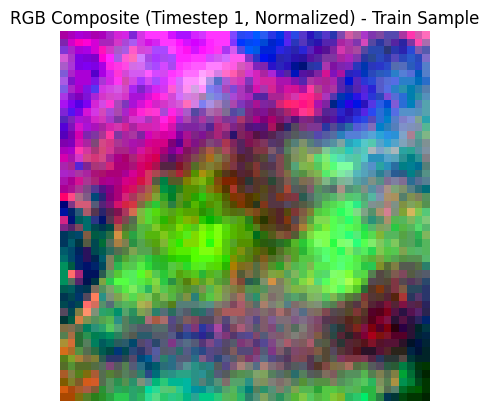

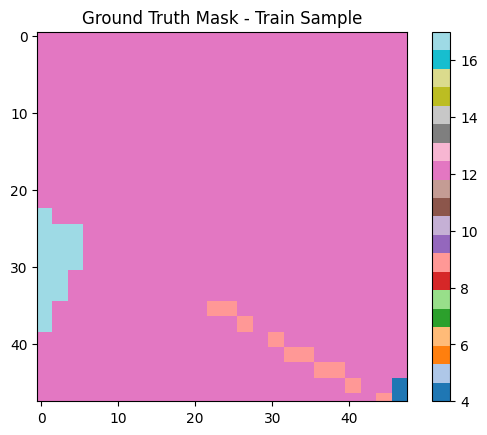


Validation Sample:
x_val shape: torch.Size([288, 48, 48])
y_val shape: torch.Size([48, 48])
x_val dtype: torch.float32
y_val unique labels: tensor([  2,   6,   7,   9,  14,  15,  17, 255])


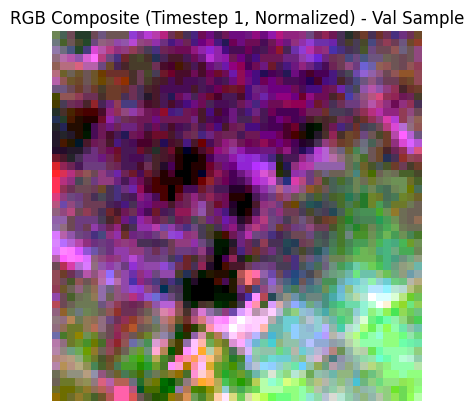

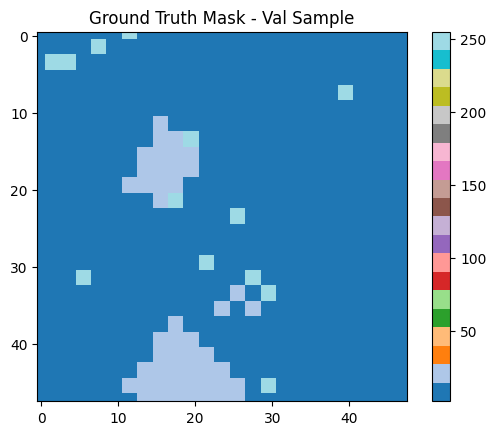

In [6]:
# Visualizing the images (rgb composite for multispectral input)
def normalize_band(band):
    """Contrast stretch to 2–98 percentile"""
    p2, p98 = np.percentile(band, (2, 98))
    return np.clip((band - p2) / (p98 - p2), 0, 1)
    

# Print from train dataset
x_train, y_train = train_ds[0]
print("Train Sample:")
print(f"x_train shape: {x_train.shape}")  # Expected: (288, 48, 48)
print(f"y_train shape: {y_train.shape}")  # Expected: (48, 48)")
print(f"x_train dtype: {x_train.dtype}")
print(f"y_train unique labels: {torch.unique(y_train)}")  # Sanity check

# Extract bands 4, 3, 2 from timestep 1
b2 = 1   # Blue
b3 = 2   # Green
b4 = 3   # Red

rgb = x_train[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Train Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_train, cmap='tab20')
plt.title("Ground Truth Mask - Train Sample")
plt.colorbar()
plt.show()



# Print from val dataset
x_val, y_val = val_ds[0]
print("\nValidation Sample:")
print(f"x_val shape: {x_val.shape}")  # Expected: (288, 48, 48)
print(f"y_val shape: {y_val.shape}")  # Expected: (48, 48)")
print(f"x_val dtype: {x_val.dtype}")
print(f"y_val unique labels: {torch.unique(y_val)}")


# For Val data
rgb = x_val[[b4, b3, b2]]  # Shape: (3, 48, 48)

r = normalize_band(rgb[0].numpy())
g = normalize_band(rgb[1].numpy())
b = normalize_band(rgb[2].numpy())

rgb_normalized = np.stack([r, g, b], axis=-1)

# Show corrected image
plt.imshow(rgb_normalized)
plt.title("RGB Composite (Timestep 1, Normalized) - Val Sample")
plt.axis("off")
plt.show()

# Show mask
plt.imshow(y_val, cmap='tab20')
plt.title("Ground Truth Mask - Val Sample")
plt.colorbar()
plt.show()

<hr>

## 2D-CNN Model 

In [7]:
class UNetBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.enc1 = UNetBlock(in_channels, 64)
        self.enc2 = UNetBlock(64, 128)
        self.enc3 = UNetBlock(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.bottleneck = UNetBlock(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = UNetBlock(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = UNetBlock(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = UNetBlock(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)        # 64 x 48 x 48
        e2 = self.enc2(self.pool(e1))  # 128 x 24 x 24
        e3 = self.enc3(self.pool(e2))  # 256 x 12 x 12

        b  = self.bottleneck(self.pool(e3))  # 512 x 6 x 6

        d3 = self.up3(b)               # 256 x 12 x 12
        d3 = self.dec3(torch.cat([d3, e3], dim=1))  # skip e3

        d2 = self.up2(d3)              # 128 x 24 x 24
        d2 = self.dec2(torch.cat([d2, e2], dim=1))  # skip e2

        d1 = self.up1(d2)              # 64 x 48 x 48
        d1 = self.dec1(torch.cat([d1, e1], dim=1))  # skip e1

        return self.final(d1)

in_channels = 9 * NUM_TIMESTEPS
model = UNet(in_channels, NUM_CLASSES).to(DEVICE)
print(model)

UNet(
  (enc1): UNetBlock(
    (block): Sequential(
      (0): Conv2d(288, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): UNetBlock(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): UNetBlock(
    (block): Sequential(
      (0): Conv2d(128, 256, kernel_siz

-> The FC layers are removed and instead a Conv2D layer is used since we want the 2D segmentation map and FC layers flatten the 2d in 1d.

## Loss Function

In [8]:
def focal_loss(logits, targets, alpha=None, gamma=2.0, ignore_index=255):
    ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=alpha, ignore_index=ignore_index)
    
    pt = torch.exp(-ce_loss)  # convert to probabilities
    focal_term = (1 - pt) ** gamma
    loss = focal_term * ce_loss

    # Mask out ignore_index (if present)
    if ignore_index is not None:
        mask = (targets != ignore_index)
        loss = loss[mask]

    return loss.mean()

In [9]:
with h5py.File(H5_PATH, 'r') as f:
    labels = f['masks'][:]  # shape: (num_tiles, H, W)
    labels_flat = labels.reshape(-1)  # flatten to 1D

# Filter out ignore_index (255) before computing weights
labels_clean = labels_flat[labels_flat != 255]
present_classes = np.unique(labels_clean)

# Compute class weights only for present classes
weights = compute_class_weight(class_weight='balanced', classes=present_classes, y=labels_clean)

# Create a full weight vector with default 1s, and update only present class weights
full_weights = np.ones(NUM_CLASSES, dtype=np.float32)
full_weights[present_classes] = weights

# Apply log smoothing and clipping to stabilize weights
smoothed_weights = np.log1p(full_weights)
smoothed_weights = np.clip(smoothed_weights, a_min=0.5, a_max=10)

# Convert to torch tensor
class_weights = torch.tensor(smoothed_weights, dtype=torch.float32).to(DEVICE)

# Print to verify
print("Class Weights:\n", class_weights)

Class Weights:
 tensor([0.6931, 1.9617, 0.5000, 3.5220, 0.5493, 1.9133, 0.9522, 0.5000, 3.5742,
        0.5000, 7.4875, 0.5758, 0.5000, 2.0697, 2.1079, 1.4883, 4.5356, 0.5000,
        3.4430, 1.7992, 0.6931, 0.6931], device='cuda:0')


In [10]:
loss_type = 'focal'  # or 'ce'

if loss_type == 'ce':
    criterion = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
elif loss_type == 'focal':
    criterion = lambda logits, targets: focal_loss(
        logits, targets,
        alpha=class_weights,  # or None if you want unweighted focal
        gamma=2.0,
        ignore_index=255
    )
else:
    raise ValueError(f"Unsupported loss_type: {loss_type}")


optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [11]:
@torch.no_grad()
def pixel_accuracy(out, target):
    """
    Calculating pixel-wise accuracy by comparing the predicted class per pixel with the 
    ground truth and compute how many pixels were correctly classified.
    
    pred: tensor of shape (B, C, H, W) - raw logits
    target: tensor of shape (B, H, W) - class labels 
    """
    preds = out.argmax(dim=1)
    return (preds == target).float().mean().item()

## Training Loop

In [12]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    t_loss, t_acc = 0.0, 0.0
    for x, y in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        t_loss += loss.item()
        t_acc  += pixel_accuracy(out, y)
    t_loss /= len(train_loader)
    t_acc  /= len(train_loader)

    train_losses.append(t_loss)
    train_accuracies.append(t_acc)

    # Validation loop
    model.eval()
    v_loss, v_acc = 0.0, 0.0

    true_counts = torch.zeros(NUM_CLASSES, dtype=torch.long, device=DEVICE)
    pred_counts = torch.zeros(NUM_CLASSES, dtype=torch.long, device=DEVICE)
    
    for x, y in tqdm(val_loader, desc=f'Epoch {epoch} Validating'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = criterion(out, y)
        v_loss += loss.item()
        v_acc  += pixel_accuracy(out, y)

        pred = out.argmax(dim=1)

        for cls in range(NUM_CLASSES):
            mask = (y == cls) & (y != 255)
            true_counts[cls] += mask.sum()
            pred_counts[cls] += ((pred == cls) & (y != 255)).sum()
    
    v_loss /= len(val_loader)
    v_acc  /= len(val_loader)

    val_losses.append(v_loss)
    val_accuracies.append(v_acc)

    print(f"Epoch {epoch}/{NUM_EPOCHS} | "
          f"Train Loss: {t_loss:.4f}, Acc: {t_acc:.4f} | "
          f"Val Loss: {v_loss:.4f}, Acc: {v_acc:.4f}")

Epoch 1 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.74it/s]


Epoch 1/15 | Train Loss: 0.8064, Acc: 0.4044 | Val Loss: 0.6851, Acc: 0.4256


Epoch 2 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.02it/s]


Epoch 2/15 | Train Loss: 0.5837, Acc: 0.5310 | Val Loss: 0.5493, Acc: 0.5797


Epoch 3 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


Epoch 3/15 | Train Loss: 0.5013, Acc: 0.5728 | Val Loss: 0.4728, Acc: 0.6018


Epoch 4 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]


Epoch 4/15 | Train Loss: 0.4652, Acc: 0.5914 | Val Loss: 0.4429, Acc: 0.6198


Epoch 5 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.99it/s]


Epoch 5/15 | Train Loss: 0.4461, Acc: 0.6042 | Val Loss: 0.4436, Acc: 0.5172


Epoch 6 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]


Epoch 6/15 | Train Loss: 0.4285, Acc: 0.6184 | Val Loss: 0.4109, Acc: 0.5325


Epoch 7 Validating: 100%|██████████| 63/63 [00:12<00:00,  5.01it/s]


Epoch 7/15 | Train Loss: 0.4141, Acc: 0.6175 | Val Loss: 0.4168, Acc: 0.6280


Epoch 8 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


Epoch 8/15 | Train Loss: 0.4047, Acc: 0.6244 | Val Loss: 0.3967, Acc: 0.6098


Epoch 9 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.97it/s]


Epoch 9/15 | Train Loss: 0.3953, Acc: 0.6304 | Val Loss: 0.3930, Acc: 0.6028


Epoch 10 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.76it/s]


Epoch 10/15 | Train Loss: 0.3889, Acc: 0.6315 | Val Loss: 0.4099, Acc: 0.5995


Epoch 11 Validating: 100%|██████████| 63/63 [00:12<00:00,  4.92it/s]


Epoch 11/15 | Train Loss: 0.3831, Acc: 0.6375 | Val Loss: 0.3868, Acc: 0.6462


Epoch 12 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.82it/s]


Epoch 12/15 | Train Loss: 0.3756, Acc: 0.6388 | Val Loss: 0.3791, Acc: 0.6489


Epoch 13 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.84it/s]


Epoch 13/15 | Train Loss: 0.3720, Acc: 0.6384 | Val Loss: 0.3696, Acc: 0.6584


Epoch 14 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.81it/s]


Epoch 14/15 | Train Loss: 0.3668, Acc: 0.6429 | Val Loss: 0.3594, Acc: 0.6406


Epoch 15 Validating: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s]

Epoch 15/15 | Train Loss: 0.3605, Acc: 0.6442 | Val Loss: 0.3499, Acc: 0.6694


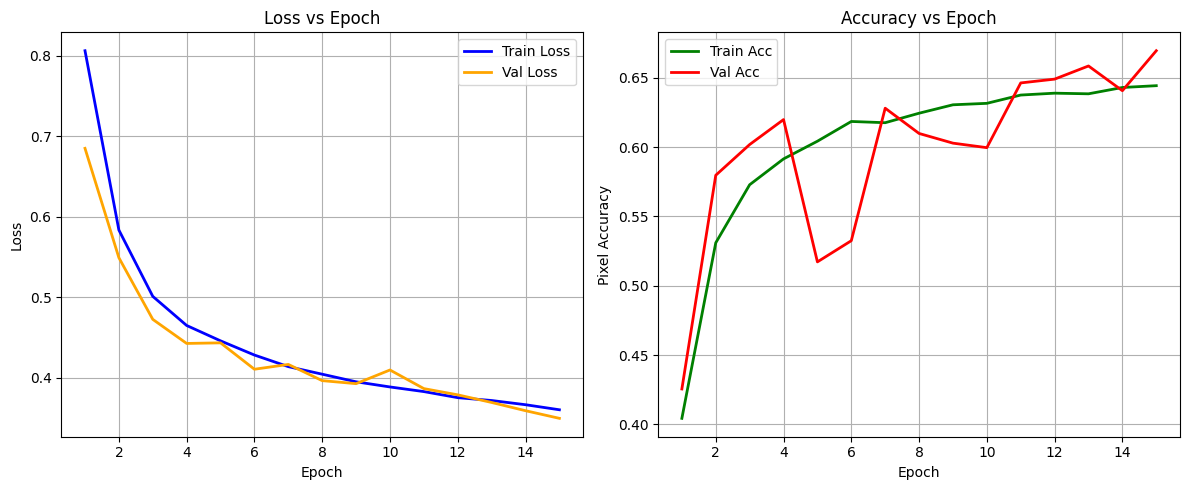

In [13]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12, 5))

# ---- LOSS ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs, val_losses,   label='Val Loss',   color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)

# ---- ACCURACY ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc', color='green', linewidth=2)
plt.plot(epochs, val_accuracies,   label='Val Acc',   color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

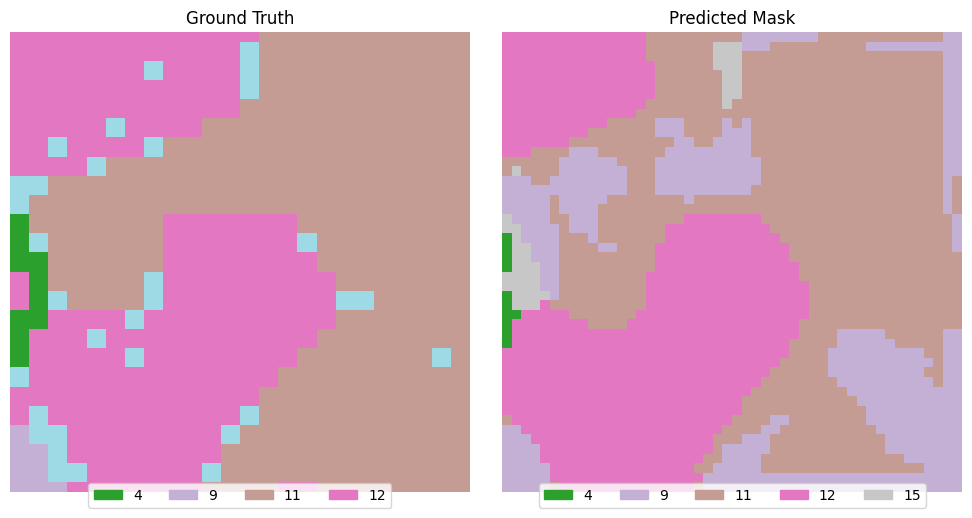


📌 Pixel-wise Accuracy: 67.88%
Ground Truth Label Counts:
  Label 4: 40 pixels
  Label 9: 26 pixels
  Label 11: 1234 pixels
  Label 12: 876 pixels
  Label 255: 128 pixels
Predicted Label Counts:
  Label 4: 11 pixels
  Label 9: 465 pixels
  Label 11: 1034 pixels
  Label 12: 751 pixels
  Label 15: 43 pixels

🟩 Ground Truth Per-Label Accuracy:
  Label 4: 40 pixels (1.74%) | Correct: 9 (22.50%)
  Label 9: 26 pixels (1.13%) | Correct: 25 (96.15%)
  Label 11: 1234 pixels (53.56%) | Correct: 839 (67.99%)
  Label 12: 876 pixels (38.02%) | Correct: 691 (78.88%)
  Label 255: 128 pixels (5.56%) | Correct: 0 (0.00%)

--------------------------------------------------------------------------------------------------------------------------------------------



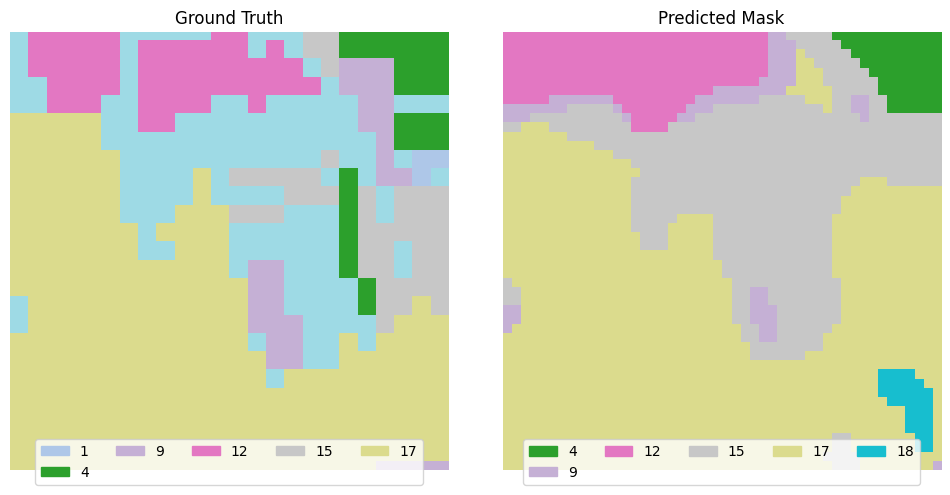


📌 Pixel-wise Accuracy: 57.86%
Ground Truth Label Counts:
  Label 1: 12 pixels
  Label 4: 116 pixels
  Label 9: 116 pixels
  Label 12: 214 pixels
  Label 15: 180 pixels
  Label 17: 1120 pixels
  Label 255: 546 pixels
Predicted Label Counts:
  Label 4: 76 pixels
  Label 9: 82 pixels
  Label 12: 226 pixels
  Label 15: 625 pixels
  Label 17: 1262 pixels
  Label 18: 33 pixels

🟩 Ground Truth Per-Label Accuracy:
  Label 1: 12 pixels (0.52%) | Correct: 0 (0.00%)
  Label 4: 116 pixels (5.03%) | Correct: 57 (49.14%)
  Label 9: 116 pixels (5.03%) | Correct: 20 (17.24%)
  Label 12: 214 pixels (9.29%) | Correct: 171 (79.91%)
  Label 15: 180 pixels (7.81%) | Correct: 62 (34.44%)
  Label 17: 1120 pixels (48.61%) | Correct: 1023 (91.34%)
  Label 255: 546 pixels (23.70%) | Correct: 0 (0.00%)

--------------------------------------------------------------------------------------------------------------------------------------------



In [14]:
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    x, y = dataset[idx]
    x = x.unsqueeze(0).to(DEVICE)
    y = y.unsqueeze(0).to(DEVICE)  # (1, H, W)

    with torch.no_grad():
        pred = model(x)
        acc = pixel_accuracy(pred, y)  # Compute pixel accuracy
        pred_mask = pred.argmax(dim=1).squeeze().cpu()

    y = y.squeeze().cpu().numpy()
    pred_mask = pred_mask.numpy()

     # Count label occurrences
    gt_labels, gt_counts = np.unique(y, return_counts=True)
    pred_labels, pred_counts = np.unique(pred_mask, return_counts=True)

    total_gt = y.size
    total_pred = pred_mask.size
        
    
    # Define colormap
    cmap = plt.get_cmap('tab20')

    # Create legend patches (label ID and corresponding color)
    def make_legend(labels):
        patches = []
        for lbl in labels:
            if lbl == 255:  # ignore index
                continue
            color = cmap(lbl % 20)  # tab20 only supports 20 colors
            patch = mpatches.Patch(color=color, label=str(lbl))
            patches.append(patch)
        return patches

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    im0 = axs[0].imshow(y, cmap=cmap, vmin=0, vmax=19)
    axs[0].set_title("Ground Truth")
    axs[0].axis("off")
    axs[0].legend(handles=make_legend(gt_labels), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)

    im1 = axs[1].imshow(pred_mask, cmap=cmap, vmin=0, vmax=19)
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")
    axs[1].legend(handles=make_legend(pred_labels), loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=5)

    plt.tight_layout()
    plt.show()


    print(f"\n📌 Pixel-wise Accuracy: {acc:.2%}")

    print("Ground Truth Label Counts:")
    for lbl, cnt in zip(gt_labels, gt_counts):
        print(f"  Label {lbl}: {cnt} pixels")

    print("Predicted Label Counts:")
    for lbl, cnt in zip(pred_labels, pred_counts):
        print(f"  Label {lbl}: {cnt} pixels")

    print("\n🟩 Ground Truth Per-Label Accuracy:")
    for lbl, total_count in zip(gt_labels, gt_counts):
        correct_pred = np.logical_and(y == lbl, pred_mask == lbl).sum()
        total_pct = 100 * total_count / total_gt
        correct_pct = 100 * correct_pred / total_count
        print(f"  Label {lbl}: {total_count} pixels ({total_pct:.2f}%) | Correct: {correct_pred} ({correct_pct:.2f}%)")

    print()
    print('-'*140)
    print()

visualize_prediction(model, train_ds, idx=2650)
visualize_prediction(model, val_ds, idx=20)

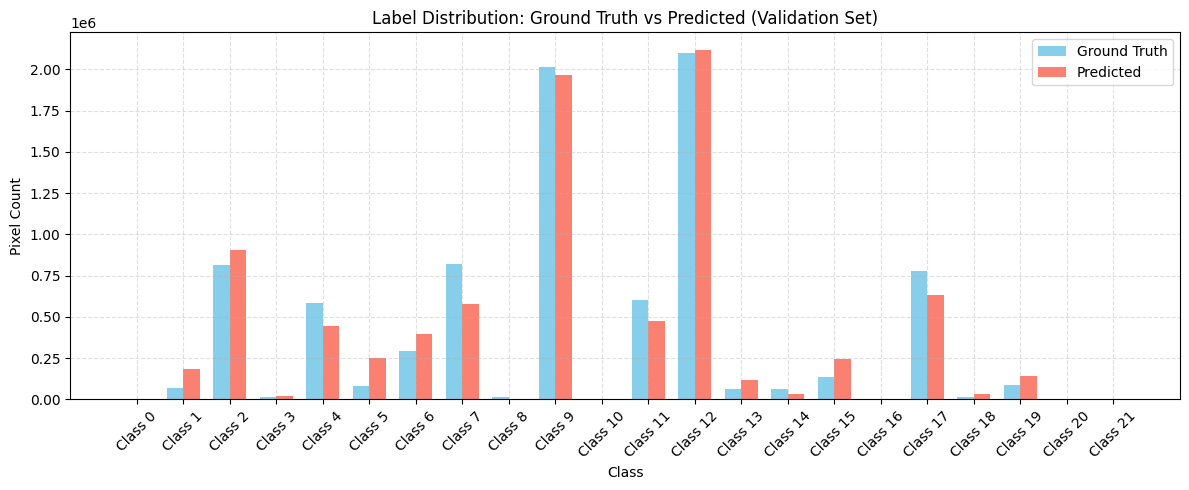

In [15]:
true_counts_cpu = true_counts.cpu().numpy()
pred_counts_cpu = pred_counts.cpu().numpy()

labels = [f'Class {i}' for i in range(NUM_CLASSES)]
x = np.arange(NUM_CLASSES)
bar_width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - bar_width/2, true_counts_cpu, width=bar_width, label='Ground Truth', color='skyblue')
plt.bar(x + bar_width/2, pred_counts_cpu, width=bar_width, label='Predicted', color='salmon')
plt.xlabel('Class')
plt.ylabel('Pixel Count')
plt.title(f'Label Distribution: Ground Truth vs Predicted (Validation Set)')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Confusion Matrix

Confusion Matrix Evaluation: 100%|██████████| 63/63 [00:12<00:00,  4.96it/s]
/tmp/ipykernel_94/780646844.py:22: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


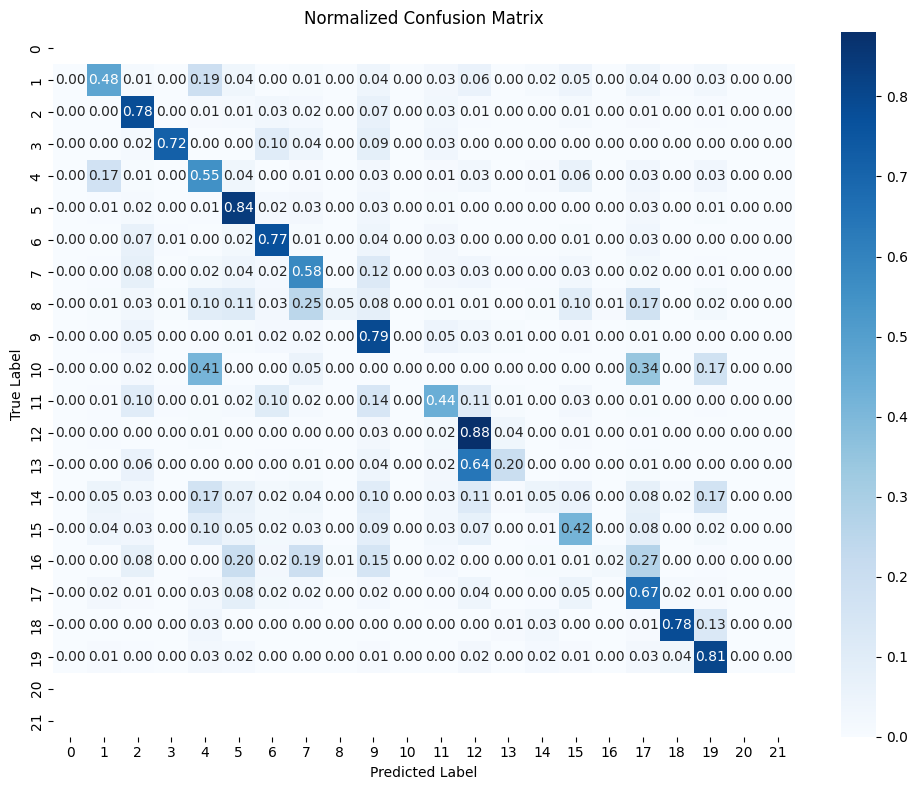

In [16]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader, desc='Confusion Matrix Evaluation'):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)               # [B, C, H, W]
        preds = out.argmax(dim=1)    # [B, H, W]

        # Flatten predictions and labels, remove 'ignore' class (255)
        mask = (y != 255)
        all_preds.append(preds[mask].cpu().numpy())
        all_labels.append(y[mask].cpu().numpy())

# Flatten into 1D
y_true = np.concatenate(all_labels)
y_pred = np.concatenate(all_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
           xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.show()

<hr>